In [1]:
### Build a Perfect FeatsNet

import os, sys
import copy as copyroot
import pandas as pd
import torch
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.vision.all import *

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df
from fastai2.tabular.all import *

# Setup -------------------------------------------

dls_tl = build_dls(target='topleft')
dls_cr = build_dls(target='center')

path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

# df2 - pixel values
df2 = pd.DataFrame([])
for i, row in df.iterrows():    
    img_np = np.array(Image.open(str(path) + row['fn']))
    df2 = pd.concat((df2, pd.Series(img_np.flatten())), axis=1)
df2 = df2.T
df2.reset_index(inplace=True, drop=True)

# df3 - pts features

feats = ['pts11','pts12','pts22']
featsnet = FeatsNet(feats = feats)

# 2*(4 + 16 + 16)
cols =  []
cols += [f'pts11_{i}' for i in range(8)]
cols += [f'pts12_{i}' for i in range(32)]
cols += [f'pts22_{i}' for i in range(32)]

df3 = pd.DataFrame([])
for i, row in df.iterrows():    
    img_np = np.array(Image.open(str(path) + row['fn']))
    tmp = featsnet.build_feats(
                torch.tensor(img_np).unsqueeze(0)
                ).squeeze(0).tolist()
    df3 = pd.concat((df3, pd.Series(tmp)), axis=1)
df3 = df3.T
df3.reset_index(inplace=True, drop=True)
df3.columns = cols

y_names = ['scalar_pxsum', 'point_topleft_x', 'point_topleft_y',
          'point_center_x', 'point_center_y']

df2_y = df[y_names]
df2 = pd.concat((df2, df3, df2_y), axis=1)

df2.head(2)

y_cols = y_names
x_cols = [col for col in df2.columns if col not in y_cols]

X = df2[x_cols]
Y = df2[y_cols]

y_tlx, y_tly, y_crx, y_cry = [Y.iloc[:,i] for i in range(1,5)]

Xt, Xv, yt_tlx, yv_tlx = train_test_split(X,  y_tlx, random_state=0)
_,  _,  yt_tly, yv_tly = train_test_split(X,  y_tly, random_state=0)
_,  _,  yt_crx, yv_crx = train_test_split(X,  y_crx, random_state=0)
_,  _,  yt_cry, yv_cry = train_test_split(X,  y_cry, random_state=0)

### Setup Tabular Dls



In [2]:
data = pd.concat((X, y_tlx, y_tly), axis=1)

y_tmp = y_tlx.copy()
y_tmp = (y_tmp - 14) / 14
y_tmp2 = y_tly.copy()
y_tmp2 = (y_tmp2 -14) / 14

# pts_cols = [e for e in X.columns if 'pts' in str(e)]
pts_cols = [
    "pts22_5",
    "pts22_29",
    "pts22_21",
    "pts11_0",
    "pts12_4",
    "pts11_2",
]

data = pd.concat((X.loc[:, pts_cols], y_tmp, y_tmp2), axis=1)

print(data.shape)

(709, 8)


In [3]:
data

,pts22_5,pts22_29,pts22_21,pts11_0,pts12_4,pts11_2,point_topleft_x,point_topleft_y
0,0.392857,0.392857,0.392857,0.178571,0.178571,0.178571,-0.214286,-0.642857
1,0.321429,0.321429,0.321429,0.142857,0.142857,0.142857,-0.357143,-0.714286
2,0.428571,0.428571,0.428571,0.107143,0.107143,0.107143,-0.142857,-0.785714
3,0.464286,0.464286,0.464286,0.142857,0.142857,0.142857,-0.071429,-0.714286
4,0.178571,0.178571,0.178571,0.142857,0.142857,0.142857,-0.642857,-0.714286
...,...,...,...,...,...,...,...,...
704,0.607143,0.607143,0.607143,0.250000,0.250000,0.250000,0.214286,-0.500000
705,0.178571,0.178571,0.178571,0.250000,0.250000,0.250000,-0.642857,-0.500000
706,0.321429,0.321429,0.321429,0.250000,0.250000,0.250000,-0.357143,-0.500000
707,0.107143,0.107143,0.107143,0.285714,0.285714,0.285714,-0.785714,-0.428571


In [6]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names=['point_topleft_x',
                                          'point_topleft_y'],
#                                  y_names='point_topleft_x', 
                                 procs=[Normalize])


ret = dls.one_batch()

ret[0].shape, ret[1].shape, ret[2].shape

AttributeError: type object 'TabularDataLoaders' has no attribute 'from_df'

In [60]:
learn = tabular_learner(dls,)

In [61]:
learn.fit(40)

epoch,train_loss,valid_loss,time
0,0.056401,0.121832,00:00
1,0.034343,0.094090,00:00
2,0.024048,0.041356,00:00
3,0.018112,0.018707,00:00
4,0.014159,0.007254,00:00
5,0.011427,0.005119,00:00
6,0.009442,0.003254,00:00
7,0.007958,0.000599,00:00
8,0.006682,0.000439,00:00
9,0.005697,0.000725,00:00


In [63]:
metrics_df(learn, "","","")

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,,,,valid,0.001257,0.029596,0.908038,0.044481,0.802224,0.002514,0.963765
1,,,,train,0.001470,0.031080,0.903318,0.046678,0.799664,0.002940,0.960627


In [64]:
preds = learn.get_preds()

In [65]:
r2_score(preds[1], preds[0])

0.9080383310353293

In [66]:
mse(preds[1], preds[0])

tensor(0.0013)

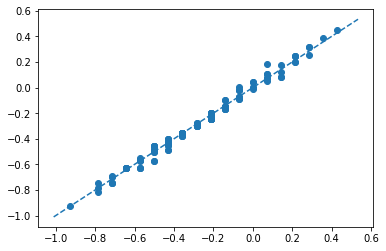

In [32]:
plt.scatter(preds[1].view(-1,2)[:,0], preds[0][:,0], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

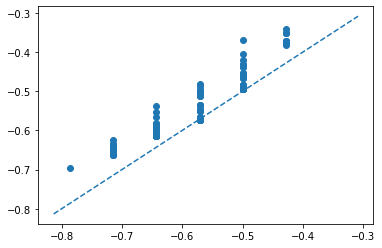

In [31]:
plt.scatter(preds[1].view(-1,2)[:,1], preds[0][:,1], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

### Fit X separately

In [51]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names='point_topleft_x',
                                 procs=[Normalize])

learn = tabular_learner(dls,)

learn.fit(40)

epoch,train_loss,valid_loss,time
0,0.273917,0.220445,00:00
1,0.176944,0.350413,00:00
2,0.123192,0.194959,00:00
3,0.093459,0.040883,00:00
4,0.075655,0.034206,00:00
5,0.064697,0.022713,00:00
6,0.057015,0.005128,00:00
7,0.052141,0.008316,00:00
8,0.049543,0.001864,00:00
9,0.046667,0.005557,00:00


In [52]:
mse(preds[0], preds[1])

tensor(0.0059)

In [53]:
r2_score(preds[1], preds[0])

0.9942224405015919

In [54]:
preds = learn.get_preds()

In [55]:
b = dls.one_batch()

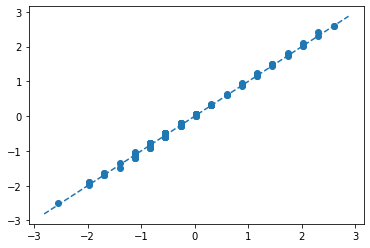

In [56]:
ind = 0
plt.scatter(preds[1][:,ind], preds[0][:,ind], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

### Fit Y separately

In [45]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names='point_topleft_y',
                                 procs=[Normalize])

learn = tabular_learner(dls,)

learn.fit(40)

epoch,train_loss,valid_loss,time
0,0.251250,0.180354,00:00
1,0.159448,0.306302,00:00
2,0.111233,0.092313,00:00
3,0.092214,0.044178,00:00
4,0.076223,0.041777,00:00
5,0.063737,0.004573,00:00
6,0.056637,0.013347,00:00
7,0.049540,0.004935,00:00
8,0.044018,0.001785,00:00
9,0.037781,0.002300,00:00


In [46]:
mse(preds[0], preds[1])

tensor(0.0160)

In [47]:
preds = learn.get_preds()

In [48]:
b = dls.one_batch()

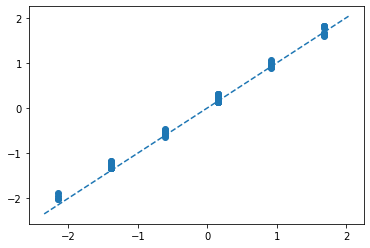

In [49]:
ind = 0
plt.scatter(preds[1][:,ind], preds[0][:,ind], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

In [50]:
r2_score(preds[1], preds[0])

0.9942224405015919

### Understand normalizing Y #1

In [5]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names=['point_topleft_x'],
                                 procs=[Normalize])

In [6]:
learn = tabular_learner(dls,)

learn.fit(40)

epoch,train_loss,valid_loss,time
0,0.057849,0.113788,00:00
1,0.033695,0.041982,00:00
2,0.022740,0.032447,00:00
3,0.017018,0.007917,00:00
4,0.013571,0.008683,00:00
5,0.010796,0.003743,00:01
6,0.008732,0.001399,00:00
7,0.007687,0.001110,00:00
8,0.006922,0.000490,00:00
9,0.006127,0.000273,00:00


In [7]:
preds = learn.get_preds()

In [8]:
mse(preds[0], preds[1])

tensor(0.0034)

In [9]:
r2_score(preds[1],preds[0])

0.9540888670813334

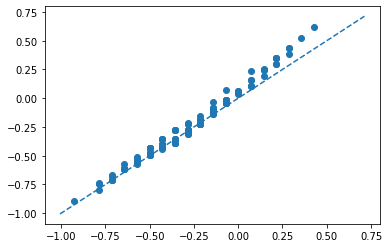

In [10]:
ind = 0
plt.scatter(preds[1][:,ind], preds[0][:,ind], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

### Understand normalizing Y #2

In [82]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names='point_topleft_x',
                                 procs=[Normalize])

In [83]:
learn = tabular_learner(dls,)

learn.fit(40)

epoch,train_loss,valid_loss,time
0,0.352868,0.140440,00:00
1,0.230837,0.262872,00:00
2,0.165112,0.180258,00:00
3,0.127327,0.020043,00:00
4,0.102049,0.018281,00:00
5,0.083863,0.024022,00:00
6,0.070500,0.004135,00:00
7,0.060434,0.006490,00:00
8,0.054529,0.003922,00:00
9,0.051627,0.003309,00:00


In [84]:
preds = learn.get_preds()

In [85]:
mse(preds[0], preds[1])

tensor(0.0024)

In [86]:
r2_score(preds[1],preds[0])

0.9977130621461284

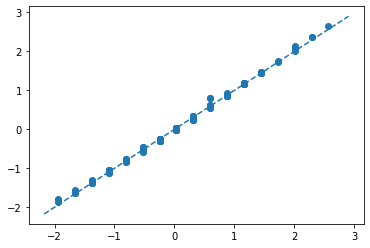

In [87]:
ind = 0
plt.scatter(preds[1][:,ind], preds[0][:,ind], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

### ScratchPad

In [36]:
from fastai2.tabular.all import *

In [37]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names='point_topleft_x',
                                 procs=[Normalize])

AttributeError: type object 'TabularDataLoaders' has no attribute 'from_df'

In [31]:
dls.y_names

(#1) ['point_topleft_x']

In [32]:
dls.ys

,point_topleft_x
208,-1.707245
30,0.272343
665,-0.010455
184,-0.576052
451,-0.010455
...,...
87,-1.141648
616,-0.293254
285,-1.141648
97,-0.858850


In [21]:
data[:3]

,pts22_5,pts22_29,pts22_21,pts11_0,pts12_4,pts11_2,point_topleft_x,point_topleft_y
0,0.392857,0.392857,0.392857,0.178571,0.178571,0.178571,-0.214286,-0.642857
1,0.321429,0.321429,0.321429,0.142857,0.142857,0.142857,-0.357143,-0.714286
2,0.428571,0.428571,0.428571,0.107143,0.107143,0.107143,-0.142857,-0.785714


In [25]:
dls.ys

,point_topleft_x
31,0.000000
175,-0.285714
396,-0.428571
528,-0.285714
444,-0.214286
...,...
479,-0.500000
566,0.142857
375,-0.214286
176,0.071429


In [26]:
dls.y_names

(#1) ['point_topleft_x']

In [24]:
dls.after_batch

Pipeline: ReadTabBatch

In [19]:
dls.after_batch(data[:3])

AttributeError: 'DataFrame' object has no attribute 'with_cont'

In [17]:
data.dtypes

pts22_5            float64
pts22_29           float64
pts22_21           float64
pts11_0            float64
pts12_4            float64
pts11_2            float64
point_topleft_x    float64
point_topleft_y    float64
dtype: object

In [14]:
df.dtypes

fn                 object
digit_class         int64
scalar_top          int64
scalar_bottom       int64
scalar_pxsum        int64
point_topleft_x     int64
point_topleft_y     int64
point_center_x      int64
point_center_y      int64
dtype: object

In [12]:
b = dls.one_batch()
b[2].min()

tensor(-0.7857)

In [125]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_block=RegressionBlock(n_out=1),
#                                  y_names=['point_topleft_x'],
                                 y_names='point_topleft_x',
                                 procs=[Normalize])
b = dls.one_batch()
b[2].min()

AttributeError: type object 'TabularDataLoaders' has no attribute 'from_df'

In [124]:
dls.y

652   -1.346479
504   -1.068370
676   -0.234043
213   -1.902698
300   -0.234043
         ...   
491   -1.068370
691    1.156503
556    0.878394
231   -1.624588
135    0.044066
Name: point_topleft_x, Length: 568, dtype: float32

In [103]:
rb = RegressionBlock(n_out=2)

In [105]:
rb.batch_tfms

(#0) []

In [106]:
rb.dls_kwargs

{}

In [107]:
rb.item_tfms

(#1) [<class 'fastai2.data.transforms.ToTensor'>]

In [108]:
rb.type_tfms

(#1) [RegressionSetup: (Tabular,object) -> encodes
(object,object) -> encodes (Tabular,object) -> decodes
(object,object) -> decodes]